# Homework 3

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.patches import Ellipse

# 1. Uncertainty ellipses for HW1

In [2]:
df = pd.read_pickle('hw1_data.pkl')
df.head()

,ID,x,y,sigma_y,sigma_x,rho_xy
0,1,201,592,61,9,-0.84
1,2,244,401,25,4,0.31
2,3,47,583,38,11,0.64
3,4,287,402,15,7,-0.27
4,5,203,495,21,5,-0.33


Best-fit b: 34.048
Best-fit m: 2.240


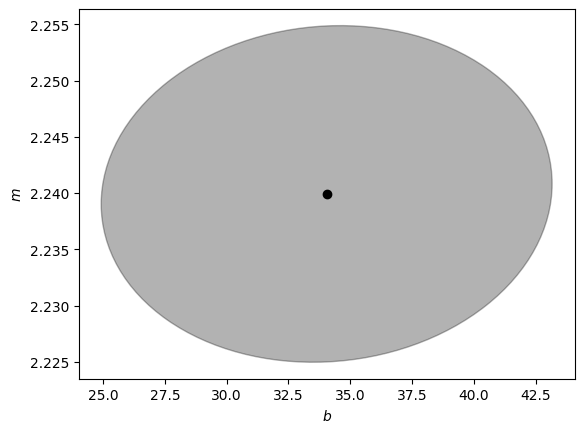

In [3]:
df1 = df.loc[df.ID > 4]

def lin_regress(x, y, sigma_y):
    def into_array(v):
        if not isinstance(v, np.ndarray):
            return np.array(v)
        
    (x, y, sigma_y) = map(into_array, (x, y, sigma_y))
    N = len(x)
    
    A = np.ones((N, 2))
    A[:, 1] = x  # ones in first col, x values in second col
    Y = y.reshape((N, 1))
    C_inv = (1. / (sigma_y ** 2)).reshape((N, 1))
    
    theta = np.linalg.solve(A.T @ (C_inv * A), A.T @ (C_inv * Y))
    cov = np.linalg.inv(A.T @ (C_inv * A))
    return theta, cov

theta, cov = lin_regress(df1.x, df1.y, df1.sigma_y)

b1, m1 = theta[0].item(), theta[1].item()
print(f"Best-fit b: {b1:.3f}")
print(f"Best-fit m: {m1:.3f}")

# find eigenvalues of covariance matrix
eigval, eigvec = np.linalg.eig(cov)
std_err1 = np.sqrt(eigval)
angle1 = np.arccos(np.dot(eigvec[:, 0], np.array([1, 0])))

fig, ax = plt.subplots()
el = Ellipse((b1, m1), width=std_err1[0], height=std_err1[1], angle=angle1,
             color='black', alpha=0.3)
ax.add_patch(el)
ax.plot(b1, m1, 'ko', zorder=1)
ax.set_xlabel("$b$")
ax.set_ylabel("$m$")
plt.show()

Best-fit b: 213.273
Best-fit m: 1.077


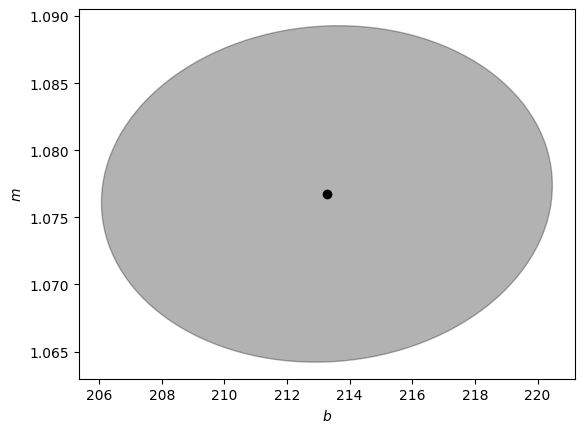

In [4]:
df2 = df.copy()

def lin_regress(x, y, sigma_y):
    def into_array(v):
        if not isinstance(v, np.ndarray):
            return np.array(v)
        
    (x, y, sigma_y) = map(into_array, (x, y, sigma_y))
    N = len(x)
    
    A = np.ones((N, 2))
    A[:, 1] = x  # ones in first col, x values in second col
    Y = y.reshape((N, 1))
    C_inv = (1. / (sigma_y ** 2)).reshape((N, 1))
    
    theta = np.linalg.solve(A.T @ (C_inv * A), A.T @ (C_inv * Y))
    cov = np.linalg.inv(A.T @ (C_inv * A))
    return theta, cov

theta, cov = lin_regress(df2.x, df2.y, df2.sigma_y)

b2, m2 = theta[0].item(), theta[1].item()
print(f"Best-fit b: {b2:.3f}")
print(f"Best-fit m: {m2:.3f}")

# find eigenvalues of covariance matrix
eigval, eigvec = np.linalg.eig(cov)
std_err2 = np.sqrt(eigval)
angle2 = np.arccos(np.dot(eigvec[:, 0], np.array([1, 0])))

fig, ax = plt.subplots()
el = Ellipse((b2, m2), width=std_err2[0], height=std_err2[1], angle=angle2,
             color='black', alpha=0.3)
ax.add_patch(el)
ax.plot(b2, m2, 'ko', zorder=1)
ax.set_xlabel("$b$")
ax.set_ylabel("$m$")
plt.show()

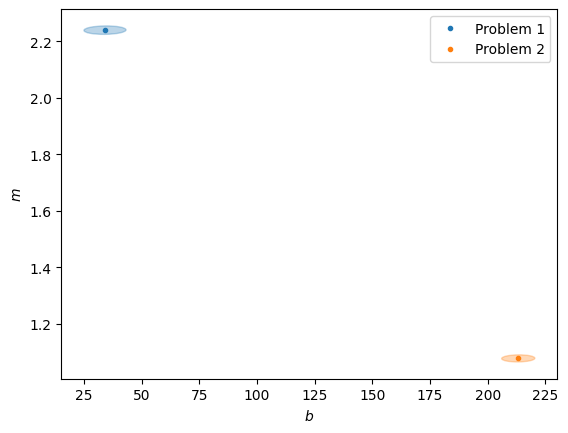

In [5]:
# On the same plot for comparison
fig, ax = plt.subplots()

el = Ellipse((b1, m1), width=std_err1[0], height=std_err1[1], angle=angle1,
             color='C0', alpha=0.3)
ax.add_patch(el)
ax.plot(b1, m1, '.', color='C0', zorder=1, label='Problem 1')

el = Ellipse((b2, m2), width=std_err2[0], height=std_err2[1], angle=angle2,
             color='C1', alpha=0.3)
ax.add_patch(el)
ax.plot(b2, m2, '.', color='C1', zorder=1, label='Problem 2')
ax.legend()
ax.set_xlabel("$b$")
ax.set_ylabel("$m$")
plt.show()

# 2. Standard error for HW2

In [6]:
import pickle
import hw2_utils as u
from tqdm.auto import tqdm

# Load the data
with open("hw2_data.pkl", "rb") as f:
    data = pickle.load(f).T

t_i = data[0]
sigma_i = data[1]
y_i = data[-1]

data = (t_i, sigma_i, y_i)

Testing frequencies:   0%|          | 0/1485 [00:00<?, ?value/s]

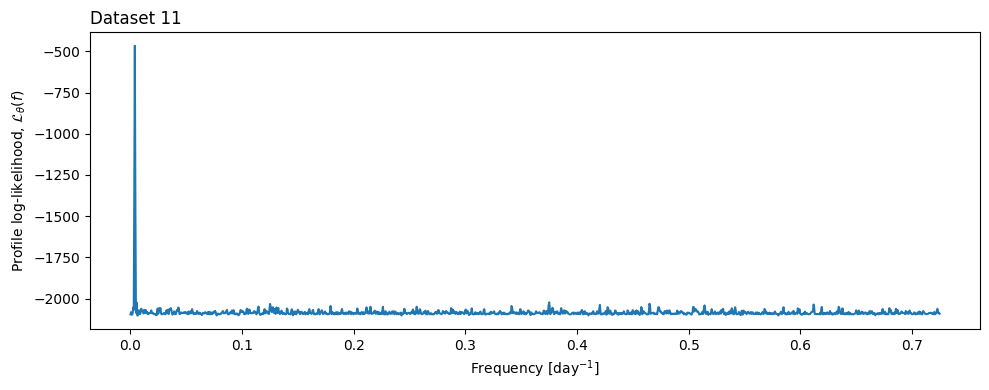

In [7]:
# Compute profile log-likelihood
# Profile out all parameters except frequency
# Result: log-likelihood function that depends only on f

def compute_freq_grid():
    freqs = 1 / np.diff(t_i)
    max_f = 0.5 * np.median(freqs)  # approx Nyquist
    f_width = 1 / 2048
    freq_grid = np.arange(0, max_f + f_width/2, step=f_width)
    return freq_grid

freq_grid = compute_freq_grid()
freq_search_logls = np.zeros_like(freq_grid)

data = (t_i, y_i, sigma_i)
for j, freq in enumerate(tqdm(freq_grid, desc="Testing frequencies", unit="value")):
    _, logl = u.max_likelihood_estimate_profile(u.two_signal_model, [0, 1, 1, 1, 1], [freq], data)
    freq_search_logls[j] = logl
    
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(freq_grid, freq_search_logls)
ax.set_title("Dataset 11", loc="left")
ax.set_xlabel("Frequency [day$^{-1}$]")
ax.set_ylabel("Profile log-likelihood, $\\mathcal{L}_{\\theta}(f)$")
fig.tight_layout()
plt.show()

In [8]:
def fit_parabola(x, y):
    """interpolate parabola through three points"""
    X = np.array([[_x**2, _x, 1] for _x in x])
    y = np.reshape(y, (-1, 1))
    theta = np.linalg.solve(X, y)
    a, b, c = theta[:, 0]
    return a, b, c

# find best frequency
index = np.argmax(freq_search_logls)
s = slice(index - 1, index + 2)
a, b, c = fit_parabola(freq_grid[s], freq_search_logls[s])
f_vertex = -0.5 * b / a
print(f"The best fit frequency is {f_vertex:.3e} days^-1, e.g. a period of {1/f_vertex:.1f} days.")

# standard error
fisher_info = - 2 * a  # = - d^2 parabola / df^2
var_lower_bound = 1 / fisher_info
std_err = np.sqrt(var_lower_bound)
print(f"The standard error estimated by the Cramér-Rao bound is {std_err:.3e} days^-1.")

The best fit frequency is 3.895e-03 days^-1, e.g. a period of 256.7 days.
The standard error estimated by the Cramér-Rao bound is 1.124e-05 days^-1.


Using error propagation, we can compute the standard error on the period. $T = f^{-1}$, so
$$
\sigma_T^2
\approx \left| \frac{dT}{df} \right|^2_{f=f_{\text{best}}} \sigma_f^2
= \left| -f^{-2}_{\text{best}} \right|^2 \sigma_f^2
= f^{-4}_{\text{best}} \sigma_f^2
$$

In [9]:
var_T = 1/f_vertex**4 * var_lower_bound
std_err_T = np.sqrt(var_T)
print(f"The Cramér-Rao bound on the period is a standard error of {std_err_T:.3e} days.")

The Cramér-Rao bound on the period is a standard error of 7.411e-01 days.


# 3. Problems 2, 4, 10 from 1710.06068

## Problem 2

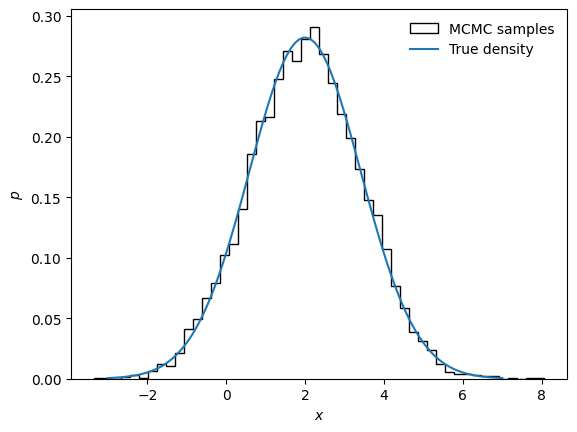

In [10]:
from scipy.stats import norm

rng = np.random.default_rng()

def p(x):
    """Return probability density p(x) = N(mu=2, var=2)"""
    return norm.pdf(x, loc=2, scale=np.sqrt(2))

def sample_q(x):
    """Draw a sample x' from q(x'|x) = N(mu=x, var=1)."""
    return rng.normal(loc=x, scale=1)

def mcmc_step(x_0):
    """implements one MCMC step and returns the next sample"""
    x_1 = sample_q(x_0)
    r = rng.uniform()
    if p(x_1) / p(x_0) > r:
        return x_1
    else:
        return x_0
    
def mcmc(x_0, n_steps=1000):
    samples = np.zeros((n_steps + 1,))
    samples[0] = x_0
    for i in range(n_steps):
        samples[i + 1] = mcmc_step(samples[i])
    return samples

samples = mcmc(0, n_steps=20000)

plt.hist(samples, density=True, bins=50, histtype='step', color='black', label='MCMC samples')
xvals = np.linspace(-3, 7, 100)
plt.plot(xvals, p(xvals), color='C0', label='True density')
plt.xlabel('$x$')
plt.ylabel('$p$')
plt.legend(frameon=False)
plt.show()

## Problem 4

### (a) two-dimensional Gaussian density

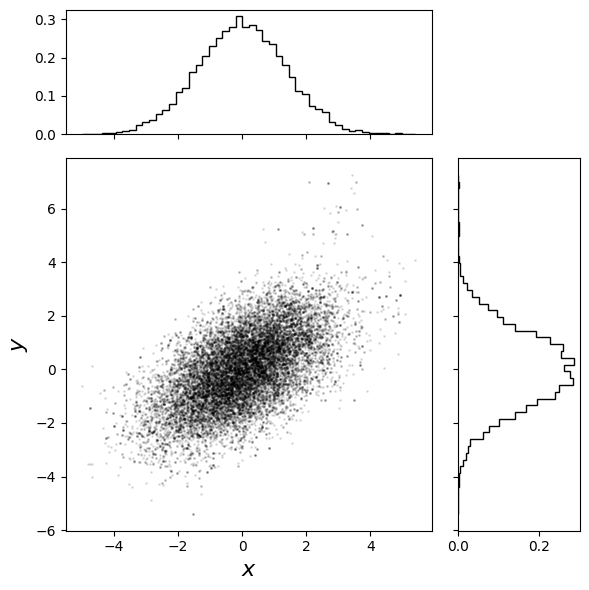

In [11]:
from scipy.stats import multivariate_normal

rng = np.random.default_rng()

def p(x):
    """Return probability density"""
    cov = np.array([[2.0, 1.2], [1.2, 2.0]])
    return multivariate_normal.pdf(x, mean=None, cov=np.array([[2.0, 1.2], [1.2, 2.0]]))

def sample_q(x):
    """Draw a sample x' from q(x'|x) = mvN(mu=x, var=I)."""
    return rng.multivariate_normal(mean=x, cov=np.eye(2))

def mcmc_step(x_0):
    """implements one MCMC step and returns the next sample"""
    x_1 = sample_q(x_0)
    r = rng.uniform()
    if p(x_1) / p(x_0) > r:
        return x_1
    else:
        return x_0
    
def mcmc(x_0, n_steps=1000):
    samples = np.zeros((n_steps + 1, 2))
    samples[0] = x_0
    for i in range(n_steps):
        samples[i + 1] = mcmc_step(samples[i])
    return samples

samples = mcmc(np.array([0, 0]), n_steps=20000)

fig, axs = plt.subplots(2, 2, figsize=(6, 6), sharex='col', sharey='row',
                        gridspec_kw=dict(width_ratios=[3, 1], height_ratios=[1, 3]))

axs[0, 1].axis('off')

hist_kw = dict(histtype='step', color='black', bins=50, density=True)
axs[0, 0].hist(samples[:, 0], **hist_kw)
axs[1, 1].hist(samples[:, 1], orientation='horizontal', **hist_kw)

axs[1, 0].scatter(samples[:, 0], samples[:, 1], s=1, alpha=0.1, color='black')
axs[1, 0].set_xlabel('$x$', fontsize=16)
axs[1, 0].set_ylabel('$y$', fontsize=16)

fig.tight_layout()

plt.show()

### (b) two-dimensional rectangular tophat density

Note that I change the initial sample point to (4, 4) instead of (0, 0) such that $p(x) \neq 0$. Because of our acceptance-rejection method, we will thus _never_ go to a point where $p(x) = 0$.

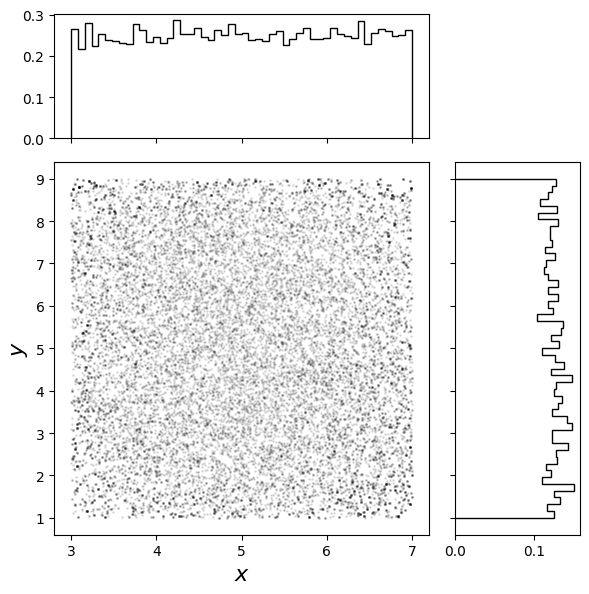

In [12]:
from scipy.stats import uniform

rng = np.random.default_rng()

def p(x):
    """Return probability density"""
    p_x = uniform.pdf(x[0], loc=3, scale=4)
    p_y = uniform.pdf(x[1], loc=1, scale=8)
    return p_x * p_y

def sample_q(x):
    """Draw a sample x' from q(x'|x) = mvN(mu=x, var=I)."""
    return rng.multivariate_normal(mean=x, cov=np.eye(2))

def mcmc_step(x_0):
    """implements one MCMC step and returns the next sample"""
    x_1 = sample_q(x_0)
    r = rng.uniform()
    if p(x_1) / p(x_0) > r:
        return x_1
    else:
        return x_0
    
def mcmc(x_0, n_steps=1000):
    samples = np.zeros((n_steps + 1, 2))
    samples[0] = x_0
    for i in range(n_steps):
        samples[i + 1] = mcmc_step(samples[i])
    return samples

samples = mcmc(np.array([4, 4]), n_steps=20000)

fig, axs = plt.subplots(2, 2, figsize=(6, 6), sharex='col', sharey='row',
                        gridspec_kw=dict(width_ratios=[3, 1], height_ratios=[1, 3]))

axs[0, 1].axis('off')

hist_kw = dict(histtype='step', color='black', bins=50, density=True)
axs[0, 0].hist(samples[:, 0], **hist_kw)
axs[1, 1].hist(samples[:, 1], orientation='horizontal', **hist_kw)

axs[1, 0].scatter(samples[:, 0], samples[:, 1], s=1, alpha=0.1, color='black')
axs[1, 0].set_xlabel('$x$', fontsize=16)
axs[1, 0].set_ylabel('$y$', fontsize=16)

fig.tight_layout()

plt.show()

## Problem 10

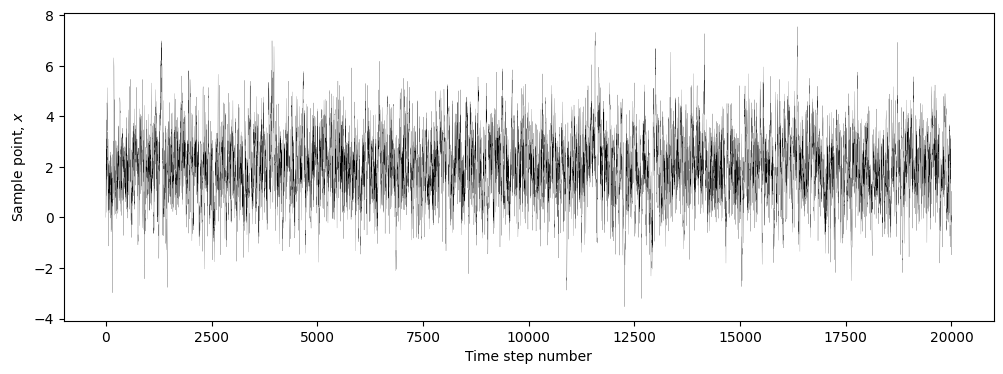

Q1: 2.031, 2.032
Q2: 2.084, 1.754
Q3: 1.992, 2.036
Q4: 1.962, 1.973


In [13]:
from scipy.stats import norm

rng = np.random.default_rng()

def p(x):
    """Return probability density p(x) = N(mu=2, var=2)"""
    return norm.pdf(x, loc=2, scale=np.sqrt(2))

def sample_q(x):
    """Draw a sample x' from q(x'|x) = N(mu=x, var=1)."""
    return rng.normal(loc=x, scale=1)

def mcmc_step(x_0):
    """implements one MCMC step and returns the next sample"""
    x_1 = sample_q(x_0)
    r = rng.uniform()
    if p(x_1) / p(x_0) > r:
        return x_1
    else:
        return x_0
    
def mcmc(x_0, n_steps=1000):
    samples = np.zeros((n_steps + 1,))
    samples[0] = x_0
    for i in range(n_steps):
        samples[i + 1] = mcmc_step(samples[i])
    return samples

samples = mcmc(0, n_steps=20000)

plt.figure(figsize=(12, 4))
plt.plot(samples, color='black', lw=0.1)
plt.xlabel('Time step number')
plt.ylabel('Sample point, $x$')
plt.show()

q1 = samples[:5_000]
q2 = samples[5_000:10_000]
q3 = samples[10_000:15_000]
q4 = samples[15_000:20_000]

print(f'Q1: {np.mean(q1):.3f}, {np.var(q1):.3f}')
print(f'Q2: {np.mean(q2):.3f}, {np.var(q2):.3f}')
print(f'Q3: {np.mean(q3):.3f}, {np.var(q3):.3f}')
print(f'Q4: {np.mean(q4):.3f}, {np.var(q4):.3f}')

We can see that the sample points have quite well traversed the space of $x$, which is a heuristic that seems to indicate convergence.

We can also see that the empirical variance and mean in each of the quadrants is approximately correct (2 and 2), and Q3-4 seem to be better than Q1-2 (though Q4's mean is worse than Q3's, its variance is better), implying convergence of the chain.